In [1]:
import os
import gc
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = "0"

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.figure as fig
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
# print("statsmodels version: "+sm.__version__)
%matplotlib inline

In [3]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, LeakyReLU
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import initializers
from tensorflow.keras import callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import losses
import sys
print(f"Python {sys.version}")
print(f"TensorFlow Version: {tf.__version__}")
print()
tf.keras.backend.clear_session()
# tf.keras.backend.set_floatx('float64')
tf.executing_eagerly()

Python 3.6.12 (default, Sep 15 2020, 12:49:50) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-37)]
TensorFlow Version: 2.3.0



True

In [4]:
tf.compat.v1.logging.get_verbosity()

20

In [5]:
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [6]:
tf.compat.v1.logging.get_verbosity()

40

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the desired GPU
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        print("Memory growth set to: "+str(tf.config.experimental.get_memory_growth(gpus[0])))
    except RuntimeError as e:
        # Visible devices must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPU
Memory growth set to: True


<hr style="border:5px solid white"> </hr>

## Helper Functions

In [34]:
#Generate lagged Y to use as input matrix(X) and future lagged Y as output matrix(Y) for the NeuralNet
def ts2IF(ts, s, h):
    m = ts.shape[0] - s - h + 1
    x = pd.DataFrame(np.random.randint(10, size=(m, s)))
    y = pd.DataFrame(np.random.randint(10, size=(m, h)))
    for i in range(m):
        for j in range(x.shape[1]): x.iloc[i, j] = ts[i + j]
        for j in range(y.shape[1]): y.iloc[i, j] = ts[i + j + s]
    #x['ones'] = np.ones(x.shape[0])                        # add first column of all ones
    x.columns = ["lag"+str(x) if(x!=0) else "origY" for x in range(1,s+1)]
#     x.insert(0,"ones",np.ones(x.shape[0]).astype(int),True)                # add first column of all ones
    return (x, y)

def chopr(x,y,te,te_size,tr_size):
    te2 = te + te_size
    tr = te - tr_size
#     print("te="+str(te))
#     print("te_size="+str(te_size))
#     print("tr_size="+str(tr_size))
    x_e = x[te:te2]
    y_e = y[te:te2]
    x_r = x[tr:te]
    y_r = y[tr:te]
    
#     print("test: x_e("+str(te)+" .. "+str(te2-1)+")")
#     print("test: y_e("+str(te)+" .. "+str(te2-1)+")")
#     print("train: x_r("+str(tr)+" .. "+str(te-1)+")")
#     print("train: y_r("+str(tr)+" .. "+str(te-1)+")")
    return(x_e, y_e, x_r, y_r)

def shift_rm(xy1,xy2):
    d1 = xy1[1].shape[0]
    d2 = xy2[1].shape[0]
    gap = d1 - d2
    x = pd.DataFrame(np.random.randint(10, size=(d1, xy1[0].shape[1])))
    y = pd.DataFrame(np.random.randint(10, size=(d1, xy1[1].shape[1])))
    for i in range(y.shape[0]):
        if i<gap:
            for j in range(x.shape[1]): x.iloc[i,j] = xy1[0].iloc[i+d2,j].copy()
            y.iloc[i,:] = xy1[1].iloc[i+d2].copy()
        else:
            for j in range(x.shape[1]): x.iloc[i,j] = xy2[0].iloc[i-gap,j].copy()
            y.iloc[i,:] = xy2[1].iloc[i-gap].copy()
#     print("old x_r="+str(xy1[0].shape))
#     print("old y_r="+str(xy1[1].shape))
#     print("x_r="+str(x.shape))
#     print("y_r="+str(y.shape))
#     print("old x_e="+str(xy2[0].shape))
#     print("old y_e="+str(xy2[1].shape))
#     print("x_e="+str(xy2[0].shape))
#     print("y_e="+str(xy2[1].shape))
    x.columns = xy1[0].columns
    y.columns = xy1[1].columns
    return(x,y)

#Generic Rescale Method
from sklearn.preprocessing import minmax_scale, scale
def rescale(inp,act_func='tanh'):
    if(act_func=='tanh'): return  minmax_scale(inp,feature_range=(-1,1))
    if(act_func=='sigmoid'): return  minmax_scale(inp,feature_range=(0,1))
    if(act_func=='linear' or act_func=='elu'): return  inp
    else: return inp

# Reverse scaling
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler((-1,1))
# scaler.fit(lagY)
# yp_unscaled = scaler.inverse_transform(yp)
# yp_unscaled.shape

def eval(y,yp):
    import math
    roundTo = 5
    m = y.shape[0]
    e = y - yp
    yt = y - y.mean()
    sse = e.dot(e)
    sst = yt.dot(yt)
    rSq = round((1 - ((sse)/(sst))),roundTo)
    mape = round(((np.absolute(e)/np.absolute(y)).sum())*100/m,roundTo)
    t = (np.absolute(e)/(np.absolute(y)+np.absolute(yp)))
#     print(t.sum()*200/m)
    smape = round(((np.absolute(e)/(np.absolute(y)+np.absolute(yp))).sum())*200/m,roundTo)
    # smape  = 200 * (e.abs / (yy.abs + yp.abs)).sum / m
    mse = round((sse/m),roundTo)
    rmse = round(math.sqrt(mse),roundTo)
#     return(rSq,mape,mse,rmse,sse,sst)
    return(format(rSq,'.4f'),format(mape,'.2f'),format(smape,'.2f'),format(mse,'.2f'),format(rmse,'.2f'),format(sse,'.2f'),format(sst,'.2f'))

def plotHistory(fit_history,ls="MAPE"):
    #Get training loss
    loss = fit_history.history['loss']
    # val_loss = fit_history.history['val_loss']

    # Create count of the number of epochs
    epoch_count = range(1, len(loss) + 1)

#     # Visualize loss history - Plotting Loss vs Number of Epochs during training
    plt.figure(num=0,figsize=(6,3))
    plt.plot(epoch_count, loss)
    # plt.plot(val_loss)
    plt.legend(['Training Loss - '+str(ls), 'Validation Loss - '+str(ls)])
    plt.xlabel('Epochs')
    plt.ylabel(ls)
    plt.title("Loss vs Epochs")
    plt.show()

#     print("_________________________________________________________________________________________")
    print("Min Training Loss = " + str(np.min(loss)) + " ",end='')
    print("at Epoch " + str(np.argmin(loss) + 1))
    # print("Min Validation Loss = " + str(np.min(val_loss)) + " ",end='')
    # print("at Epoch " + str(np.argmin(val_loss) + 1))
#     print("__________________________________________________________________________________________")

#Generic Model Build
def buildModel(modelName,nfeat,nhidden,act_func='tanh',optimzer=optimizers.Adam(),loss_func='mean_squared_error',dropout=None,horizons=14):
#     print("Create a " + modelName + " with "+ str(nfeat) +" input, "+str(nhidden)+" hidden nodes")
    model = Sequential()
    if modelName == 'perceptron':
        model.add(Dense(1,input_dim=nfeat,activation=act_func[0]))                  #1st Hidden Layer - 1 neuron
    if modelName == 'NeuralNet_3L':
        model.add(Dense(nhidden,input_dim=nfeat,activation=act_func[0]))         #1st Hidden Layer
        model.add(Dense(1,activation=act_func[1]))                               #Output Layer
    if modelName == 'NeuralNet_3L_MH':
        model.add(Dense(nhidden,input_dim=nfeat,activation=act_func[0]))
        model.add(Dropout(0.1))
        model.add(Dense(14,activation=act_func[1]))                              #Output Layer - MultiHorizon(10)
    if modelName == 'NeuralNet_4L':
        model.add(Dense(nhidden,input_dim=nfeat,activation=act_func[0]))         #1st Hidden Layer
        model.add(Dense(nhidden,activation=act_func[1]))                         #2nd Hidden Layer
        if dropout: 
            model.add(Dropout(dropout))
        model.add(Dense(1,activation=act_func[2]))                               #Output Layer
    if modelName == 'NeuralNet_4L_MH':
        model.add(Dense(nhidden,input_dim=nfeat,activation=act_func[0]))         #1st Hidden Layer
        model.add(Dense(nhidden,activation=act_func[1]))                         #2nd Hidden Layer
#         if not dropout: model.add(Dropout(dropout))
        model.add(Dense(Y.shape[1],activation=act_func[2]))                              #Output Layer - MultiHorizon(10)
    # model.compile(loss='mean_absolute_percentage_error', optimizer=optimzer, metrics=['mean_absolute_percentage_error'])
    model.compile(loss=loss_func, optimizer=optimzer, metrics=['mean_absolute_percentage_error'])
    return model
#     model.compile(loss='mean_squared_error', optimizer=optimzer, metrics=['mean_absolute_percentage_error'])
#model.add(Dense(nhidden,activation=act_func[0]))   
#model.add(LeakyReLU())
#model.add(Dropout(0.18))
def rollingValidate(model,train,x,y,kt,horizons,callbk,nEpoch,nBatch,plot,p1=False,p2=False,shuffle=True):
    TR_RATIO = 0.6
    m = y.shape[0]
    tr_size = int(m * TR_RATIO)
    te_size = int(m - tr_size)
    te = int(tr_size)
    if kt < 0: kt = te_size
    print("m = "+str(m)+", tr_size = "+str(tr_size)+", te_size = "+str(te_size)+", kt = "+str(kt)+", horizons = "+str(horizons))
    
    (x_e, y_e, x_r, y_r) = chopr (x, y, te, te_size, tr_size)
#     x_r = x_r[1000:]
#     y_r = y_r[1000:]
    print("Training shape"+str(x_r.shape))
    print("Training shape"+str(y_r.shape))
    print("Testing shape"+str(x_e.shape))
    print("Testing shape"+str(y_e.shape))
    smapearr = [x for x in range(10,(10+horizons))]
#     for h in range(1,horizons+1):
# #         print(type(y_r))
#         yr =  y_r[h-1]
#         inp = y_e[h-1] #.values.tolist()
#         yrw = inp[:-h]
#         for i in range(h):
#             yrw.insert(i,inp[i])
#         yrw = np.array(yrw)
#         rSqr, maper, smaper, mser, rmser, sser, sstr = eval(y_e[h-1],yrw)
#         smapearr[h-1] = smaper

    rt = 0
#     print("number of re-trainings required = "+str(int((te_size/kt)+1)))
    for i in range(y_e.shape[0]):
        if i%kt == 0:
            rt = rt + 1
            if i > 0:
                x_r, y_r = shift_rm((x_r,y_r),((x_e.iloc[i-kt:i], y_e.iloc[i-kt:i])))
            if train:
                print("training set: "+str(x_r.shape))
                if callbk==1:
                    callb = callbacks.EarlyStopping(monitor='loss', restore_best_weights=True, patience=40,verbose=1)
                else: callb = None   #batch_input_shape=(10, 5, 1)
#                 fit_history = model.fit(x_r, y_r,validation_split=0.0,shuffle=True,epochs=nEpoch, \
#                                         batch_input_shape=(64, 44, 1),verbose=0, callbacks=callb) #callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,show_epoch_progress=False)]  workers=10, use_multiprocessing=True,
                fit_history = model.fit(x_r, y_r,validation_split=0.0,shuffle=shuffle,epochs=nEpoch, \
                                        batch_size=nBatch,verbose=0, callbacks=callb) #callbacks=[tfa.callbacks.TQDMProgressBar(leave_epoch_progress=False,show_epoch_progress=False)]  workers=10, use_multiprocessing=True,
            if plot: plotHistory(fit_history)
#     print("\nOut-Sample Results")
#     rw = np.array([2.47,3.79,4.6,5.23,5.75,6.18,6.61,6.94,7.29,7.70]) #RW results - mape for 50% TR
    rw = np.array([float(x) for x in smapearr]) #calculated using python
    beats = []
    prediction = model.predict(x_e,batch_size=x_e.shape[0])
#     print(type(prediction))
#     print(prediction.shape)
#     print(type(y_e))
#     print(y_e.shape)
#     print(y_e.columns)
    rSq  = [x for x in range(y.shape[1])]
    mse  = [x for x in range(y.shape[1])]
    sse  = [x for x in range(y.shape[1])]
    sst  = [x for x in range(y.shape[1])]
    rmse = [x for x in range(y.shape[1])]
    mape = [x for x in range(y.shape[1])]
    smape = [x for x in range(y.shape[1])]
    maxdif = 0
    maxdifh = 0
    for h in range(1,y.shape[1]+1):
        yf = prediction[:,h-1]
        rSq[h-1], mape[h-1], smape[h-1], mse[h-1], rmse[h-1], sse[h-1], sst[h-1] = eval(y_e.values[:,h-1],yf)
#         diff = (rw[h-1] - float(mape[h-1]))
#         if rw[h-1] >= float(mape[h-1]): beats.append(h)
#         if diff > maxdif:
#             maxdif = diff
#             maxdifh = h
        if p1:
            print(str(smape[h-1]))  #,str(rw[h-1])
#             if h < 10: print("h="+str(h)+"  -> "+" smape= "+str(smape[h-1])+","+str(rw[h-1]))    
#             else: print("h="+str(h)+" -> "+" smape= "+str(smape[h-1])+","+str(rw[h-1]))  
#             if h != 10: print("h="+str(h)+"  -> "+"rsq = "+str(rSq[h-1])+" mape = "+str(mape[h-1])+","+str(format(rw[h-1],'.2f'))+" mse = "+str(mse[h-1])+" rmse = "+str(rmse[h-1]) +" sst = "+str(sst[h-1])) #" sse = "+str(sse[h-1]) +
#             else: print("h="+str(h)+" -> "+"rsq = "+str(rSq[h-1])+" mape = "+str(mape[h-1])+","+str(format(rw[h-1],'.2f'))+" mse = "+str(mse[h-1])+" rmse = "+str(rmse[h-1]) +" sst = "+str(sst[h-1])) #" sse = "+str(sse[h-1]) +)
#     if p2: 
#         print("Beats RW at "+str(len(beats))+" values of h="+str(beats))
#         print("Max difference = "+str(maxdif)+" at horizon h="+str(maxdifh))
    return (rSq, mape, smape, mse, rmse, sse, sst, beats, prediction, y_e)

<hr style="border:5px solid white"> </hr>

# Data

In [13]:
dat = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/CLEANED_35.csv')
# dat = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/national-history2.csv')
# data = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/CLEANED_35.csv')
# dat = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/USCOVID_BY_STATE.csv')
# dat.iloc[44:]
dat = dat[['deathIncrease']]
dat

,deathIncrease
0,0
1,0
2,0
3,0
4,0
...,...
386,3486
387,3685
388,5212
389,3543


## Data Augmentation

In [15]:
sarima_forecasts = pd.read_csv('SARIMA_IN+OUT_FORECASTS.csv')
sarima_forecasts.head()

,h1,h2,h3,h4,h5,h6,h7,h8,h9,h10,...,h19,h20,h21,h22,h23,h24,h25,h26,h27,h28
0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,...,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
3,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
4,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,...,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0,3.0


In [16]:
sarima_forecasts = sarima_forecasts[["h1"]]

In [18]:
orig = dat.iloc[44:-1]
# orig

In [20]:
half = pd.DataFrame((dat.iloc[44:-1].values.squeeze() + sarima_forecasts.iloc[1:].values.squeeze())/2)
# half

In [24]:
quater = pd.DataFrame((orig.values.squeeze() + half.values.squeeze())/2)
# quater

In [25]:
third_quater = pd.DataFrame((half.values.squeeze() + sarima_forecasts.iloc[1:].values.squeeze())/2)
# third_quater

In [26]:
augmented_ts = np.arange(2*half.shape[0]).tolist()
for i in range(0,half.shape[0]):
    augmented_ts[2*i] = orig.iloc[i][0]
    augmented_ts[2*i+1] = half.iloc[i][0]

In [51]:
# augmented_ts = np.arange(4*half.shape[0]).tolist()
# for i in range(0,half.shape[0]):
#     augmented_ts[4*i] = orig.iloc[i][0]
#     augmented_ts[4*i+1] = quater.iloc[i][0]
#     augmented_ts[4*i+2] = half.iloc[i][0]
#     augmented_ts[4*i+3] = third_quater.iloc[i][0]

In [27]:
len(augmented_ts)

692

## Data Visualization

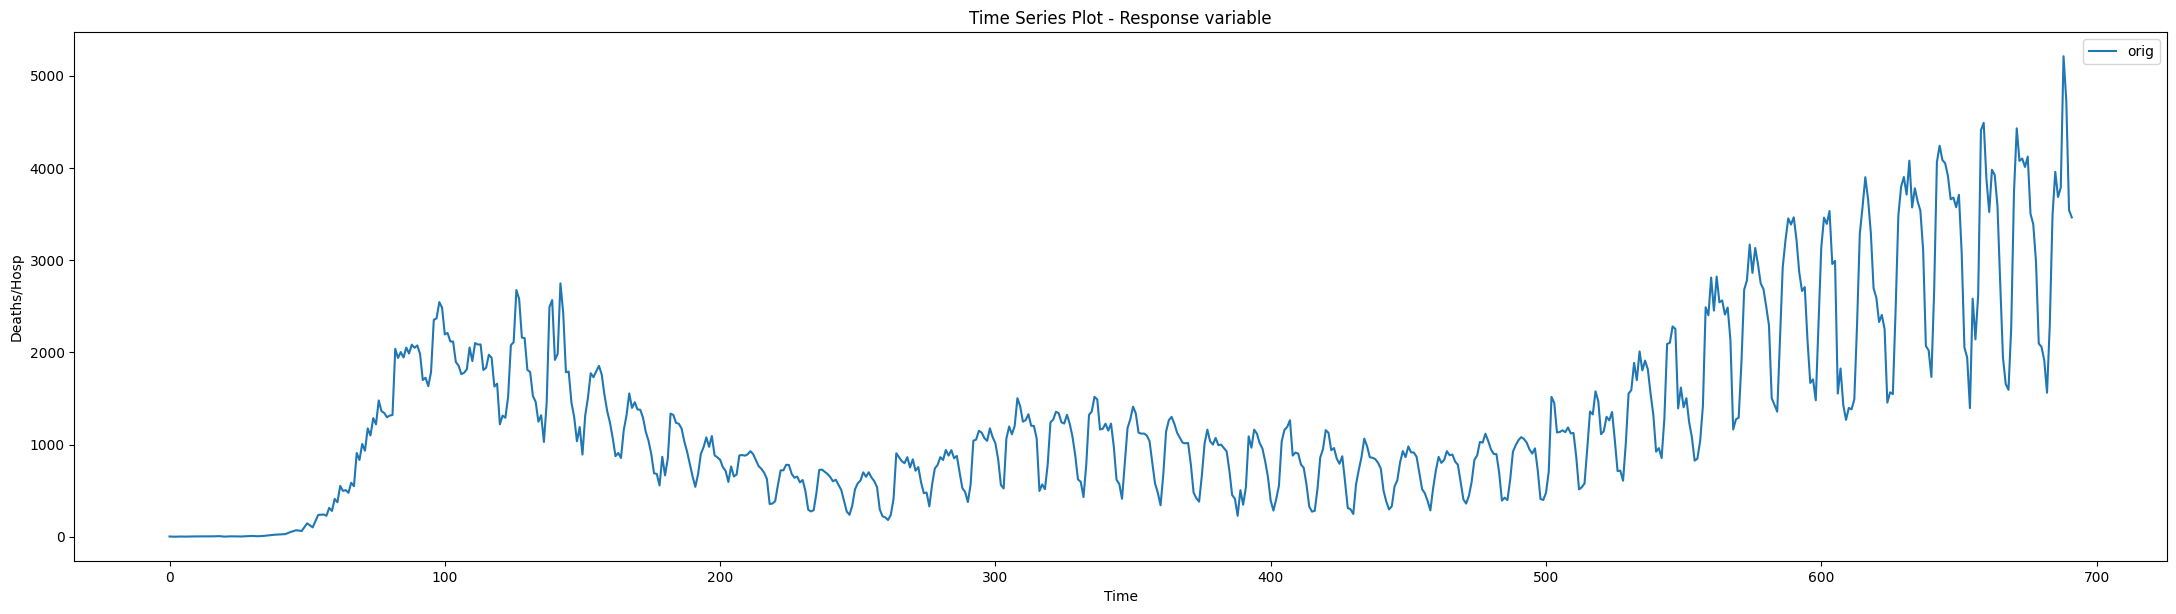

In [28]:
plt.figure(num=0, figsize=(27,7),dpi=100)
# plt.plot(dat.values.squeeze())
plt.plot(augmented_ts)
plt.legend(['orig','sarima'])
plt.xlabel('Time')
plt.ylabel('Deaths/Hosp')
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,101))
# plt.yticks(np.arange(0, 101, 10.0))
plt.title("Time Series Plot - Response variable")
plt.show()

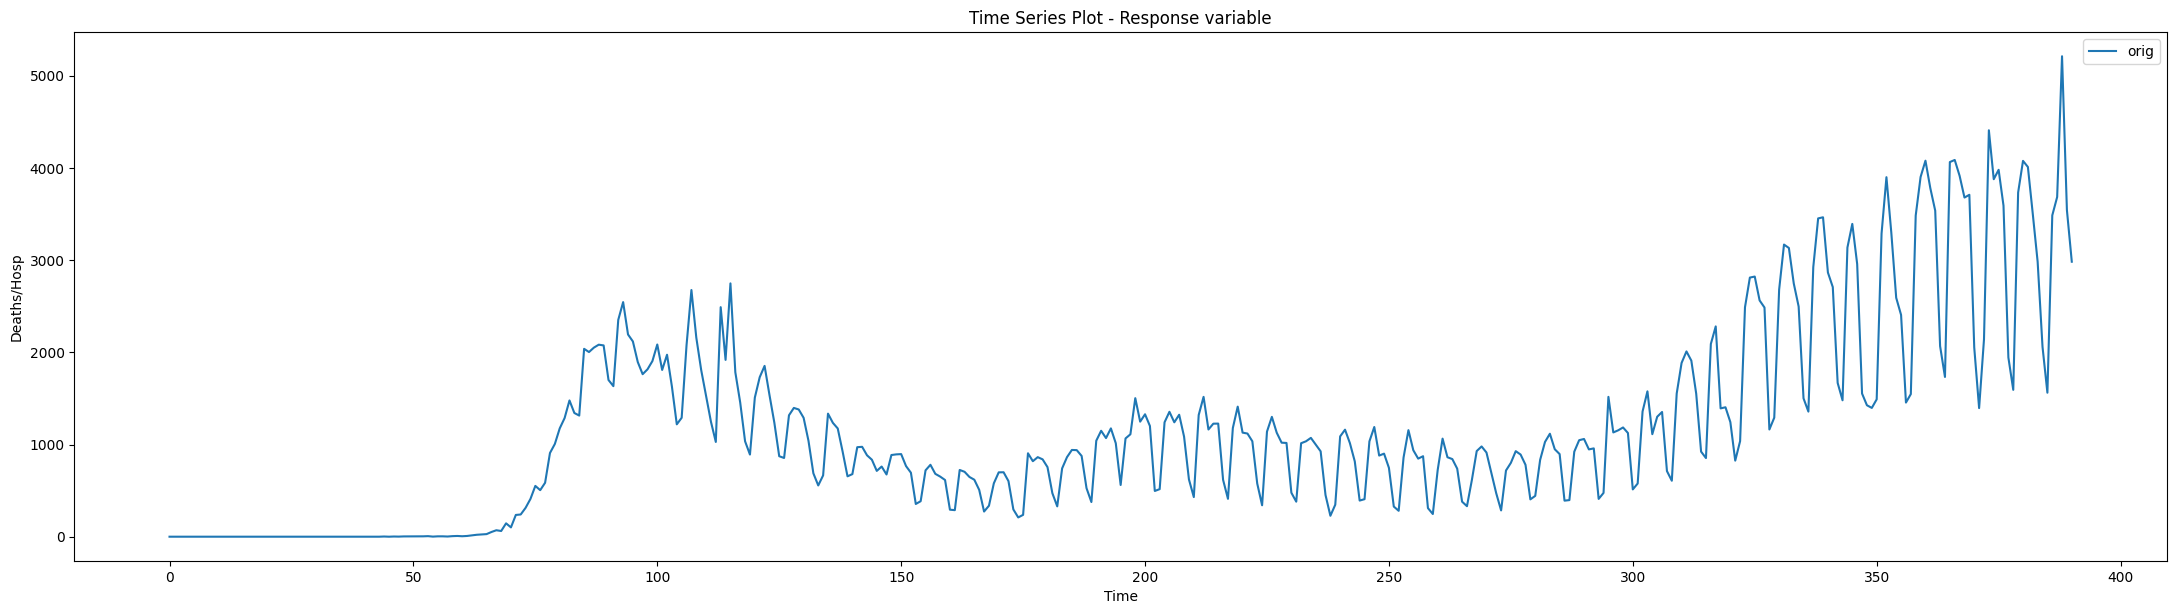

In [14]:
plt.figure(num=0, figsize=(27,7),dpi=100)
plt.plot(dat.values.squeeze())
plt.legend(['orig','sarima'])
plt.xlabel('Time')
plt.ylabel('Deaths/Hosp')
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,101))
# plt.yticks(np.arange(0, 101, 10.0))
plt.title("Time Series Plot - Response variable")
plt.show()

## Data Interpolation

In [55]:
# from scipy.interpolate import interp1d
# time = [float(x) for x in range(1,dat.shape[0]+1)]

# f2 = interp1d(time, dat.values.squeeze(), kind='cubic')
# new_time = np.arange(1, dat.shape[0]+0.5, step=0.5)

# dat = f2(new_time)

## ACF Plot

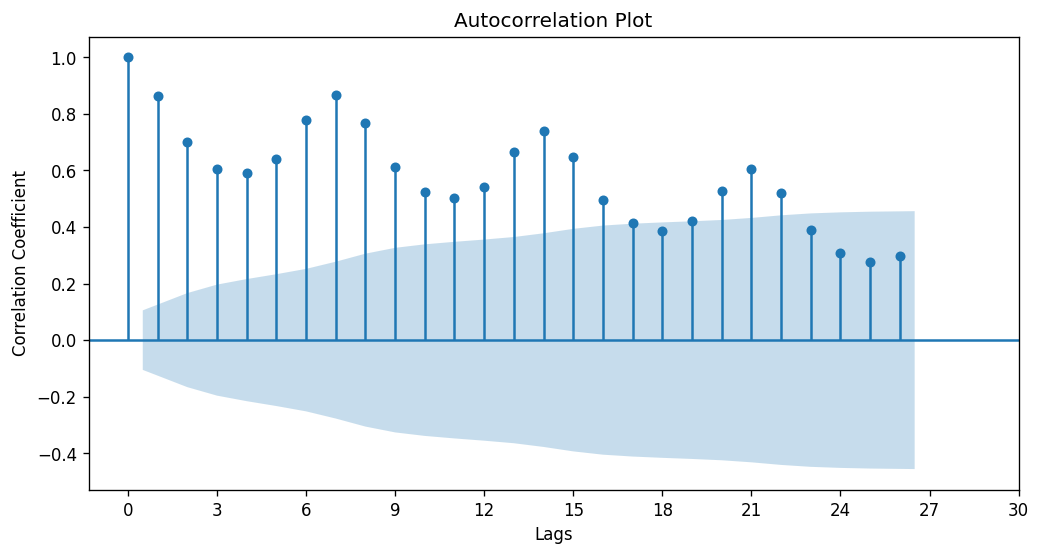

In [30]:
import statsmodels.api as sm
import statsmodels.tsa.api as tsa
fig = sm.graphics.tsa.plot_acf(dat.iloc[44:].values.squeeze())
# fig = sm.graphics.tsa.plot_acf(x=np.array(augmented_ts))
# fig.suptitle("ACF Plot")
axes = fig.axes
axes[0].set_title("Autocorrelation Plot")
axes[0].set_xlabel("Lags")
axes[0].set_ylabel("Correlation Coefficient")
axes[0].set_xticks(np.arange(0, 31, 3))
fig._set_dpi(120)
fig.set_size_inches(10,5)
fig.show()
# axes[0].set_yticks(np.arange(0, 1, 0.1))
# fig.savefig("./COVID/Test.png")

<hr style="border:5px solid white"> </hr>

<hr style="border:5px solid white"> </hr>

# Neural Nets

<hr style="border:2px solid white"> </hr>

In [31]:
augmented_ts = np.array(augmented_ts)
augmented_ts = np.reshape(augmented_ts,(-1,2))
augmented_ts = np.reshape(augmented_ts,(-1,1))
augmented_ts.shape

(692, 1)

### Generating X and Y matrices

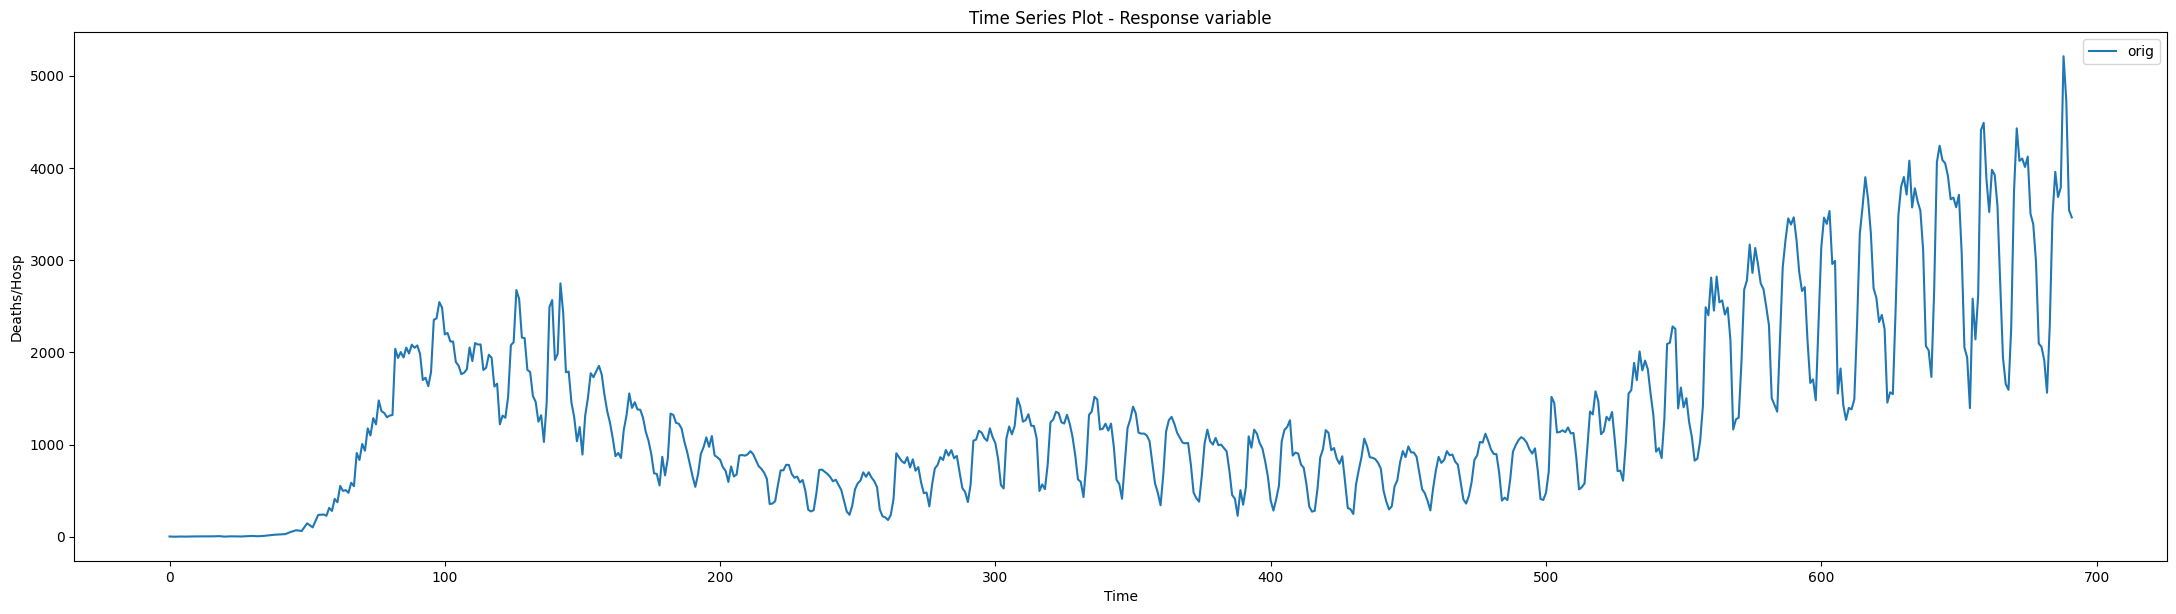

[1301.97403482] [1000637.0878879]


In [32]:
elim_samples = 43
lags = 42
horizons = 28
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(augmented_ts)
sc = MinMaxScaler(feature_range = (-1, 1))

# augmented_ts = sc.fit_transform(augmented_ts)   #Scaling 
# augmented_ts = scaler.transform(augmented_ts)   #Standarizing 

plt.figure(num=0, figsize=(27,7),dpi=100)
# plt.plot(dat.values.squeeze())
plt.plot(augmented_ts)
plt.legend(['orig','sarima'])
plt.xlabel('Time')
plt.ylabel('Deaths/Hosp')
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,101))
# plt.yticks(np.arange(0, 101, 10.0))
plt.title("Time Series Plot - Response variable")
plt.show()
print(scaler.mean_, scaler.var_)

In [35]:
# lagX, lagY = ts2IF(dat.iloc[elim_samples+1:,0].values.squeeze(),lags,horizons)
lagX, lagY = ts2IF(np.array(augmented_ts),lags,horizons)


X = pd.DataFrame(lagX)
X.columns = lagX.columns
feat = X.shape[1]
print(X.shape)

(623, 42)


In [38]:
# imp = [1, 2, 6, 7, 8, 13, 14, 15] #, 23, 28, 29, 6, 12, 4]
# imp_lags = ["lag"+str(x) for x in imp]

In [39]:
# X = X[imp_lags]

In [36]:
time = [float(x) for x in range(1,X.shape[0]+1)]
X['time'] = time
X

,lag1,lag2,lag3,lag4,lag5,lag6,lag7,lag8,lag9,lag10,...,lag34,lag35,lag36,lag37,lag38,lag39,lag40,lag41,lag42,time
0,2.000000,1.000000,0.000000,1.000000,2.000000,1.500000,1.000000,2.000000,3.000000,3.000000,...,6.500000,8.000000,11.500000,15.000000,18.000000,21.000000,22.500000,24.000000,26.000000,1.0
1,1.000000,0.000000,1.000000,2.000000,1.500000,1.000000,2.000000,3.000000,3.000000,3.000000,...,8.000000,11.500000,15.000000,18.000000,21.000000,22.500000,24.000000,26.000000,28.000000,2.0
2,0.000000,1.000000,2.000000,1.500000,1.000000,2.000000,3.000000,3.000000,3.000000,3.000000,...,11.500000,15.000000,18.000000,21.000000,22.500000,24.000000,26.000000,28.000000,39.500000,3.0
3,1.000000,2.000000,1.500000,1.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,15.000000,18.000000,21.000000,22.500000,24.000000,26.000000,28.000000,39.500000,51.000000,4.0
4,2.000000,1.500000,1.000000,2.000000,3.000000,3.000000,3.000000,3.000000,3.000000,2.500000,...,18.000000,21.000000,22.500000,24.000000,26.000000,28.000000,39.500000,51.000000,60.500000,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
618,3297.000000,2694.124784,2592.000000,2328.871723,2406.000000,2251.032826,1455.000000,1565.805539,1547.000000,2456.061023,...,3080.240437,2053.000000,1942.771257,1395.000000,2582.114887,2141.000000,2627.266876,4409.000000,4489.911584,619.0
619,2694.124784,2592.000000,2328.871723,2406.000000,2251.032826,1455.000000,1565.805539,1547.000000,2456.061023,3484.000000,...,2053.000000,1942.771257,1395.000000,2582.114887,2141.000000,2627.266876,4409.000000,4489.911584,3878.000000,620.0
620,2592.000000,2328.871723,2406.000000,2251.032826,1455.000000,1565.805539,1547.000000,2456.061023,3484.000000,3796.830108,...,1942.771257,1395.000000,2582.114887,2141.000000,2627.266876,4409.000000,4489.911584,3878.000000,3522.170158,621.0
621,2328.871723,2406.000000,2251.032826,1455.000000,1565.805539,1547.000000,2456.061023,3484.000000,3796.830108,3902.000000,...,1395.000000,2582.114887,2141.000000,2627.266876,4409.000000,4489.911584,3878.000000,3522.170158,3980.000000,622.0


In [37]:
Y = pd.DataFrame(rescale(lagY,"linear"))
print(Y.shape)
Y.head()

(623, 28)


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,24,25,26,27
0,28.0,39.5,51.0,60.5,70.0,66.0,62.0,103.5,145.0,123.0,...,410.000000,373.512119,551.000000,497.297226,505.000000,475.958459,585.000000,547.677162,908.000000,832.534469
1,39.5,51.0,60.5,70.0,66.0,62.0,103.5,145.0,123.0,101.0,...,373.512119,551.000000,497.297226,505.000000,475.958459,585.000000,547.677162,908.000000,832.534469,1006.000000
2,51.0,60.5,70.0,66.0,62.0,103.5,145.0,123.0,101.0,168.5,...,551.000000,497.297226,505.000000,475.958459,585.000000,547.677162,908.000000,832.534469,1006.000000,932.837447
3,60.5,70.0,66.0,62.0,103.5,145.0,123.0,101.0,168.5,236.0,...,497.297226,505.000000,475.958459,585.000000,547.677162,908.000000,832.534469,1006.000000,932.837447,1175.000000
4,70.0,66.0,62.0,103.5,145.0,123.0,101.0,168.5,236.0,238.5,...,505.000000,475.958459,585.000000,547.677162,908.000000,832.534469,1006.000000,932.837447,1175.000000,1098.068563


## Drop Specific Lags

In [32]:
# drop = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,20,21]
# drop_lags = ["lag"+str(x) for x in drop]
# X = X[drop_lags]

## NAS - RNN

In [ ]:
# %%time
# import autokeras as ak
# # rsX = pd.DataFrame(rescale(X,"linear"))
# # lX = rsX.values.reshape(rsX.shape[0],rsX.shape[1],1) #(batch_size, timestep/window, no. features/lags)
# # lY = Y.values.reshape(Y.shape[0],Y.shape[1],1)
# input_layer = ak.Input()
# rnn_layer = ak.RNNBlock(layer_type="lstm")(input_layer)
# dense_layer = ak.DenseBlock()(rnn_layer)
# output_layer = ak.RegressionHead()(dense_layer)

# automodel = ak.AutoModel(input_layer, output_layer, max_trials=10, loss='mean_absolute_percentage_error',metrics='mean_absolute_percentage_error',overwrite=True,objective='val_loss', project_name='NAS')
# automodel.fit(lX, Y.values, validation_split=0.4, epochs=500, batch_size=32, verbose=0)
# model = automodel.export_model()
# print(model.summary())
# rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(model,True,lX,Y,-1,horizons,callbk=1,nEpoch=1
#                                                                                        ,nBatch=32,plot=True,p1=True,p2=True)

In [18]:
true_pred = [x for ind,x in enumerate(prediction[:,1].squeeze().tolist()) if (ind+1)%2==0]
true_data = [x for ind,x in enumerate(y_e.values.squeeze()[:,1].tolist()) if (ind+1)%2==0]
dates = range(1, len(true_data) + 1)
# ytick = np.arange(0, 5000, 500)
# xtick = np.arange(0, 133, 7)
plt.figure(num=0, figsize=(20,8))
plt.plot(dates,true_data)
plt.plot(dates,true_pred)
plt.legend(['True Value','Forecasted Value'])
plt.xlabel('Days')
plt.ylabel('Daily Deaths')
# plt.axis((x1,x2,0,101))
# plt.xticks(xtick)
# plt.yticks(ytick)
plt.title("Time Series Plot - Response vs Out-Of-Sample Forecasts(h=1)")
plt.show()

NameError: name 'prediction' is not defined

<hr style="border:2px solid white"> </hr>

## Multihorizon In-Sample Results

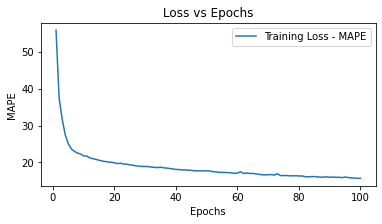

Min Training Loss = 15.619873046875 at Epoch 99


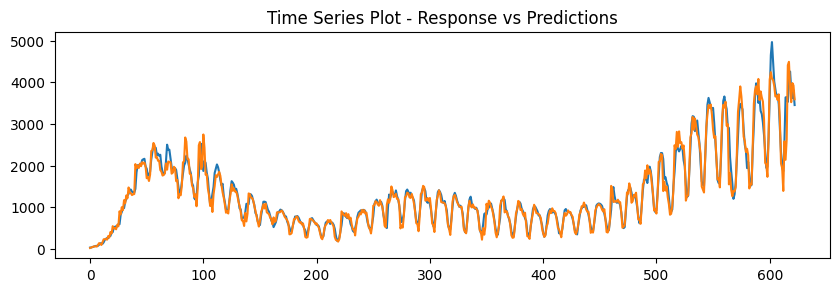

h=1  -> rsq = 0.9515 mape = 10.20 smape = 9.66 mse = 38659.80 rmse = 196.62 sse = 24085054.14 sst = 496622688.97
h=2  -> rsq = 0.9357 mape = 11.75 smape = 11.15 mse = 51326.91 rmse = 226.55 sse = 31976667.59 sst = 497055609.32
h=3  -> rsq = 0.9251 mape = 12.80 smape = 12.11 mse = 59621.37 rmse = 244.17 sse = 37144111.23 sst = 495831828.53
h=4  -> rsq = 0.9138 mape = 12.73 smape = 12.29 mse = 68380.48 rmse = 261.50 sse = 42601037.73 sst = 494348179.97
h=5  -> rsq = 0.9093 mape = 12.43 smape = 12.37 mse = 71724.57 rmse = 267.81 sse = 44684407.83 sst = 492841357.00
h=6  -> rsq = 0.9066 mape = 13.28 smape = 12.74 mse = 73813.51 rmse = 271.69 sse = 45985815.79 sst = 492175963.01
h=7  -> rsq = 0.9006 mape = 13.07 smape = 13.24 mse = 79180.68 rmse = 281.39 sse = 49329560.70 sst = 496386254.16
h=8  -> rsq = 0.8997 mape = 14.38 smape = 13.67 mse = 81180.27 rmse = 284.92 sse = 50575310.66 sst = 504364654.06
h=9  -> rsq = 0.9058 mape = 13.48 smape = 13.37 mse = 77195.78 rmse = 277.84 sse = 480929

13736

In [50]:
# # %%time
# feat = X.shape[1]
# # print(feat)
# nz = (lags+1) * 3 + 2
# model = buildModel("NeuralNet_4L_MH",feat,nz,["elu","elu","linear"],optimzer="Adamax",loss_func="mean_absolute_percentage_error",horizons=Y.shape[1]) #mean_squared_error                                   #Output Layer
# fit_history = model.fit(X, Y, epochs=100, batch_size=20,verbose=0)
# plotHistory(fit_history,"MAPE")
# yp = pd.DataFrame(model.predict(X,batch_size=100))
# hr = 1
# plt.figure(num=0, figsize=(10,3),dpi=100)
# plt.plot(yp.iloc[:,hr-1])
# plt.plot(Y.iloc[:,hr-1])
# plt.title("Time Series Plot - Response vs Predictions")
# plt.show()
# for h in range(1,15):
#     rSq, mape, smape, mse, rmse, sse, sst = eval(Y[h-1],yp[h-1])
#     print(("h="+str(h)+"  -> "+"rsq = "+str(rSq)+" mape = "+str(mape)+" smape = "+str(smape)+" mse = "+str(mse)+" rmse = "+str(rmse) +" sse = "+str(sse) +" sst = "+str(sst),"h="+str(h)+" -> "+"rsq = "+str(rSq)+" mape = "+str(mape)+" smape = "+str(smape)+" mse = "+str(mse)+" rmse = "+str(rmse) +" sse = "+str(sse) +" sst = "+str(sst))[h >= 10])
# # from tensorflow.compat.v1.keras.backend import set_session
# # from tensorflow.compat.v1.keras.backend import clear_session
# # from tensorflow.compat.v1.keras.backend import get_session
# # sess = get_session()
# # clear_session()
# # sess.close()
# # sess = get_session()
# # del model
# # gc.collect()

## Neural Nets

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 43)]              0         
_________________________________________________________________
multi_category_encoding (Mul (None, 43)                0         
_________________________________________________________________
normalization (Normalization (None, 43)                87        
_________________________________________________________________
dense (Dense)                (None, 32)                1408      
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)               

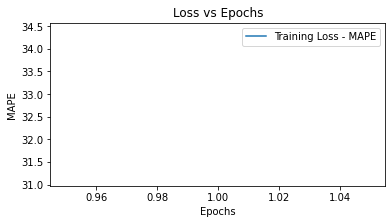

Min Training Loss = 32.77545166015625 at Epoch 1
36.72
37.25
38.55
39.18
39.29
38.48
36.18
33.24
28.83
25.90
24.82
26.09
29.20
33.78
37.63
41.18
43.08
44.17
43.77
41.86
38.70
34.43
29.92
27.19
26.90
29.28
33.74
38.82
CPU times: user 55.3 s, sys: 2.94 s, total: 58.2 s
Wall time: 1min 35s


In [46]:
%%time
feat = X.shape[1]

l1 = X.columns.tolist()
l2 = ['numerical' for x in l1]
# print(l1)
# print(l2)
col_typ = dict(zip(l1,l2))
col_typ

model = Sequential()
model.add(Dense(32,input_dim=feat, activation='linear', kernel_initializer='he_normal'))
model.add(tf.keras.layers.ReLU())
model.add(Dense(32,activation='linear', kernel_initializer='he_normal'))
model.add(tf.keras.layers.ReLU())
# model.add(Dropout(0.5))
model.add(Dense(Y.shape[1],activation='linear'))
model.compile(loss='mean_absolute_percentage_error', optimizer='Adam', metrics=['mean_absolute_percentage_error'])

# import autokeras as ak
# reg = ak.StructuredDataRegressor(max_trials=1,column_names=l1,column_types=col_typ, output_dim=Y.shape[1], loss='mean_absolute_percentage_error',metrics='mean_absolute_percentage_error',overwrite=True,objective='val_loss', project_name='NAS')
# reg.fit(x=X, y=Y, epochs=250, validation_split=0.40, validation_data=None, verbose=0)
# model = reg.export_model()
print(model.summary())
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(model,True,X,Y,-1,horizons,callbk=0,nEpoch=200
                                                                        ,nBatch=32,plot=True,p1=True,p2=True)

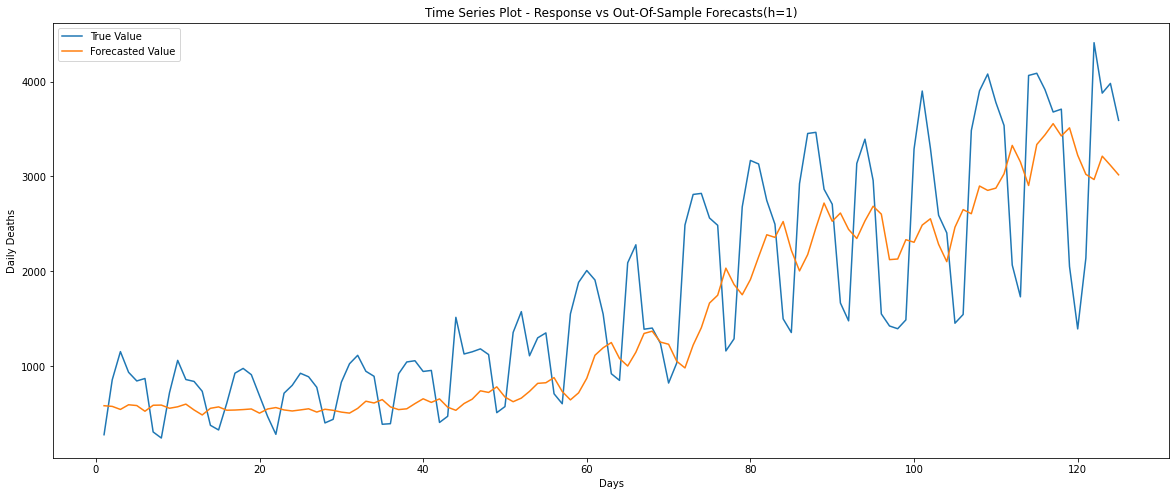

In [47]:
true_pred = [x for ind,x in enumerate(prediction[:,0].squeeze().tolist()) if (ind+1)%2==0]
true_data = [x for ind,x in enumerate(y_e.values.squeeze()[:,0].tolist()) if (ind+1)%2==0]
dates = range(1, len(true_data) + 1)
# ytick = np.arange(0, 5000, 500)
# xtick = np.arange(0, 133, 7)
plt.figure(num=0, figsize=(20,8))
plt.plot(dates,true_data)
plt.plot(dates,true_pred)
plt.legend(['True Value','Forecasted Value'])
plt.xlabel('Days')
plt.ylabel('Daily Deaths')
# plt.axis((x1,x2,0,101))
# plt.xticks(xtick)
# plt.yticks(ytick)
plt.title("Time Series Plot - Response vs Out-Of-Sample Forecasts(h=1)")
plt.show()

In [103]:
# model.save('./COVID/5CasesNonAugLg1-21-t-L-16-16-E225-b32-Min538.h5')
# dir(model.layers[6])
# model.layers

In [39]:
%%time

nmodel = tf.keras.models.load_model('./best_neural_net_model.h5')
# model.save('./COVID/5AugDoubleL1-42-t-NAS-100-200-0.50-E320-b64.h5')
print(nmodel.summary())
# rSq1, mape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = crossValidate(nmodel,True,X,Y,-1,2,nEpoch=150,nBatch=50,plot=True,p1=True,p2=True)
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(nmodel,False,X,Y,-1,2,callbk=0,nEpoch=1,nBatch=20,plot=False,p1=True,p2=True)

Model: "sequential_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_103 (Dense)            (None, 1024)              45056     
_________________________________________________________________
re_lu_52 (ReLU)              (None, 1024)              0         
_________________________________________________________________
dense_104 (Dense)            (None, 28)                28700     
Total params: 73,756
Trainable params: 73,756
Non-trainable params: 0
_________________________________________________________________
None
m = 623, tr_size = 373, te_size = 250, kt = 250, horizons = 2
Training shape(373, 43)
Training shape(373, 28)
Testing shape(250, 43)
Testing shape(250, 28)
9.52
13.06
13.61
14.59
15.85
15.00
14.53
14.22
15.71
15.96
15.80
15.70
15.91
16.64
16.97
18.16
18.22
18.86
18.98
19.81
19.16
18.92
19.13
19.76
19.92
20.34
21.62
20.87
CPU times: user 323 ms, sys: 118 ms, total: 442 ms


In [41]:
date = pd.read_csv('https://raw.githubusercontent.com/scalation/data/master/COVID/CLEANED_35.csv')
date = date[["date"]]
dates = date.iloc[date.shape[0]-125:]
dates = np.array([x[:-4]+x[-2:] for x in dates.values.squeeze().tolist()])
dates

array(['10/5/20', '10/6/20', '10/7/20', '10/8/20', '10/9/20', '10/10/20',
       '10/11/20', '10/12/20', '10/13/20', '10/14/20', '10/15/20',
       '10/16/20', '10/17/20', '10/18/20', '10/19/20', '10/20/20',
       '10/21/20', '10/22/20', '10/23/20', '10/24/20', '10/25/20',
       '10/26/20', '10/27/20', '10/28/20', '10/29/20', '10/30/20',
       '10/31/20', '11/1/20', '11/2/20', '11/3/20', '11/4/20', '11/5/20',
       '11/6/20', '11/7/20', '11/8/20', '11/9/20', '11/10/20', '11/11/20',
       '11/12/20', '11/13/20', '11/14/20', '11/15/20', '11/16/20',
       '11/17/20', '11/18/20', '11/19/20', '11/20/20', '11/21/20',
       '11/22/20', '11/23/20', '11/24/20', '11/25/20', '11/26/20',
       '11/27/20', '11/28/20', '11/29/20', '11/30/20', '12/1/20',
       '12/2/20', '12/3/20', '12/4/20', '12/5/20', '12/6/20', '12/7/20',
       '12/8/20', '12/9/20', '12/10/20', '12/11/20', '12/12/20',
       '12/13/20', '12/14/20', '12/15/20', '12/16/20', '12/17/20',
       '12/18/20', '12/19/20', '12/20

In [42]:
true_pred = [x for ind,x in enumerate(prediction[:,1].squeeze().tolist()) if (ind+1)%2==0]
true_data = [x for ind,x in enumerate(y_e.values.squeeze()[:,1].tolist()) if (ind+1)%2==0]
len(true_pred)
len(true_data)

125

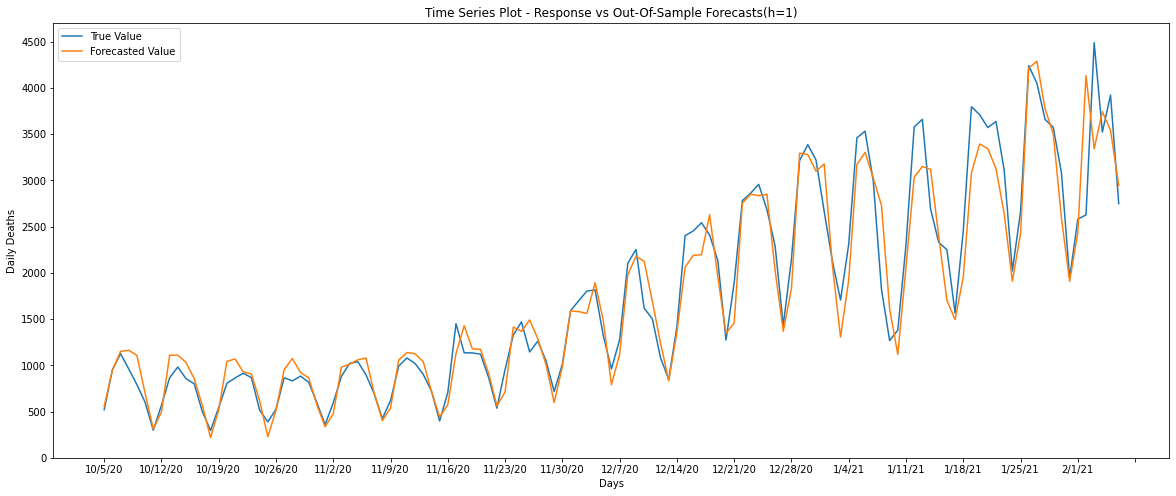

In [43]:
ytick = np.arange(0, 5000, 500)
xtick = np.arange(0, 133, 7)
plt.figure(num=0, figsize=(20,8))
plt.plot(dates,true_data)
plt.plot(dates,true_pred)
plt.legend(['True Value','Forecasted Value'])
plt.xlabel('Days')
plt.ylabel('Daily Deaths')
# plt.axis((x1,x2,0,101))
plt.xticks(xtick)
plt.yticks(ytick)
plt.title("Time Series Plot - Response vs Out-Of-Sample Forecasts(h=1)")
plt.show()
# plt.savefig("./COVID/forecasts_dates.png")

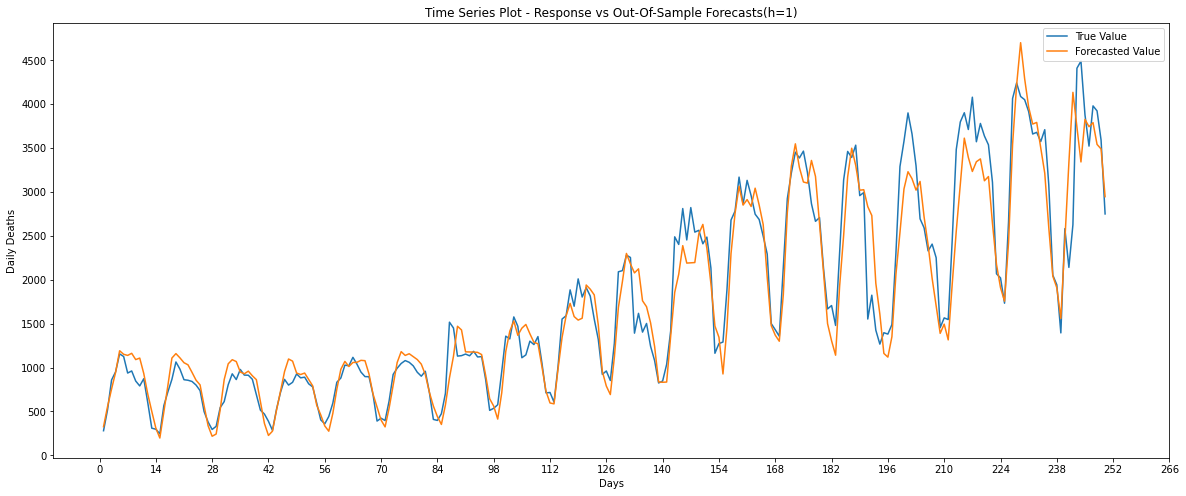

In [44]:
ytick = np.arange(0, 5000, 500)
xtick = np.arange(0, 270, 14)
plt.figure(num=0, figsize=(20,8))
range1 = range(1, y_e.shape[0] + 1)
plt.plot(range1,y_e.values.squeeze()[:,1],)
plt.plot(range1,prediction[:,1])
plt.legend(['True Value','Forecasted Value'])
plt.xlabel('Days')
plt.ylabel('Daily Deaths')
# plt.axis((x1,x2,0,101))
plt.xticks(xtick)
plt.yticks(ytick)
plt.title("Time Series Plot - Response vs Out-Of-Sample Forecasts(h=1)")
plt.show()
# plt.savefig("./COVID/forecasts_dates.png")

In [28]:
#Generic Rescale Method
from sklearn import preprocessing
def rescale(inp,act_func='tanh'):
    from sklearn.preprocessing import minmax_scale, scale
    if(act_func=='tanh'): return  minmax_scale(inp,feature_range=(-1,1))
    if(act_func=='sigmoid'): return  minmax_scale(inp,feature_range=(0,1))
    if(act_func=='linear'): return  inp
    if(act_func=='norm'): return preprocessing.normalize(inp, norm='l2')

In [68]:
# Data Pre-Processing for LSTM
import copy
X_np = copy.deepcopy(X.values.tolist())
for i in range(X.shape[0]):
    new_dim = copy.copy(X_np[i])
#     print(new_dim)
#     if i==5: break
    for j in range(X.shape[1]):
        X_np[i][j] = new_dim
#         print(X_np[i][j])
X_np1 = np.array(X_np)
print(X_np1.shape)
lX = rescale(X_np1,"linear")
# lX = rsX.values.reshape(rsX.shape[0],rsX.shape[1],1) #(batch_size, timestep/window, no. features/lags)
print(lX.shape)

(623, 42, 42)
(623, 42, 42)


In [85]:
#Build RNN - Generic
from tensorflow.keras.layers import TimeDistributed, Bidirectional, RepeatVector
from tensorflow.keras.optimizers import Adamax

def buildRNN(modelName,nUnits,act_func='linear',optimzer=Adamax(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)):
#     print("Create a " + modelName + " with "+ str(nUnits) +" units and 10 output nodes")
    model = Sequential()
    if modelName == 'GRU':
        model.add(GRU(nUnits, input_shape=(lX.shape[1], lX.shape[2])))
    if modelName == 'LSTM':
        model.add(GRU(256, activation='relu', return_sequences=True, input_shape=(lX.shape[1], lX.shape[2])))
#         model.add(RepeatVector(28))
        model.add(GRU(92, activation='relu', return_sequences=True))
#         model.add(RepeatVector(28))
        model.add(GRU(128, activation='relu'))
#         model.add(RepeatVector(28))
#         model.add(tf.keras.layers.RNN(tf.keras.layers.LSTMCell(nUnits), return_state=False, input_shape=(lX.shape[1], lX.shape[2])))
#         model.add(Bidirectional(LSTM(int(200), input_shape=(lX.shape[1], lX.shape[2]), return_sequences=False, activation='relu')))
#         model.add(RepeatVector(lX.shape[1]))
#         model.add(Bidirectional(LSTM(int(200), return_sequences=False, activation='relu')))
#         model.add(RepeatVector(lX.shape[1]))
#         model.add(LSTM(int(90), return_sequences=False, activation='relu'))
#         model.add(RepeatVector(28))
#         model.add(LSTM(int(nUnits*10), return_sequences=False, activation='elu'))
#     model.add(Dense(1024,activation=act_func))
#     model.add(tf.keras.layers.ReLU())
#     model.add(Dense(512,activation=act_func))
#     model.add(tf.keras.layers.ReLU())
#     model.add(Dense(256,activation=act_func))
#     model.add(tf.keras.layers.ReLU())
#     model.add(TimeDistributed(Dense(28)))                                     #Output Layer
    model.add(Dense(28))  
    model.compile(loss='mean_absolute_percentage_error', optimizer='adamax', metrics=['mean_absolute_percentage_error'])
#     model.compile(loss='mean_squared_error', optimizer=optimzer, metrics=['mean_squared_error'])
    model.build((None,lX.shape[1], lX.shape[2]))
    print(model.summary())
    return model

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_15 (GRU)                 (None, 42, 256)           230400    
_________________________________________________________________
gru_16 (GRU)                 (None, 42, 92)            96600     
_________________________________________________________________
gru_17 (GRU)                 (None, 128)               85248     
_________________________________________________________________
dense_7 (Dense)              (None, 28)                3612      
Total params: 415,860
Trainable params: 415,860
Non-trainable params: 0
_________________________________________________________________
None
m = 623, tr_size = 373, te_size = 250, kt = 250, horizons = 28
Training shape(373, 42, 42)
Training shape(373, 28)
Testing shape(250, 42, 42)
Testing shape(250, 28)
training set: (373, 42, 42)


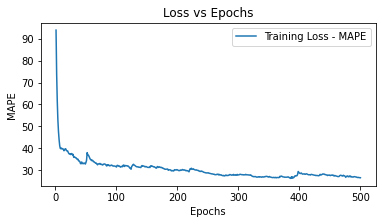

Min Training Loss = 26.203319549560547 at Epoch 385
32.16
36.44
32.03
29.35
29.86
34.65
36.43
37.09
30.80
29.91
29.63
27.78
31.84
36.36
40.66
43.92
41.70
40.09
42.94
45.77
46.55
47.17
42.49
41.18
40.99
42.09
45.69
50.44
CPU times: user 34min 57s, sys: 3min 26s, total: 38min 24s
Wall time: 14min 52s


In [87]:
%%time
# rsX = pd.DataFrame(rescale(X,"linear"))
# lX = rsX.values.reshape(rsX.shape[0],rsX.shape[1],1) #(batch_size, timestep/window, no. features/lags)
# lY = Y.values.reshape(Y.shape[0],Y.shape[1],1)
# print(lX.shape)
# print(lY.shape)
lmodel = buildRNN("LSTM",100)
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(lmodel,True,lX,Y,-1,shuffle=True,horizons=Y.shape[1],callbk=0,nEpoch=500,nBatch=32,plot=True,p1=True,p2=True)

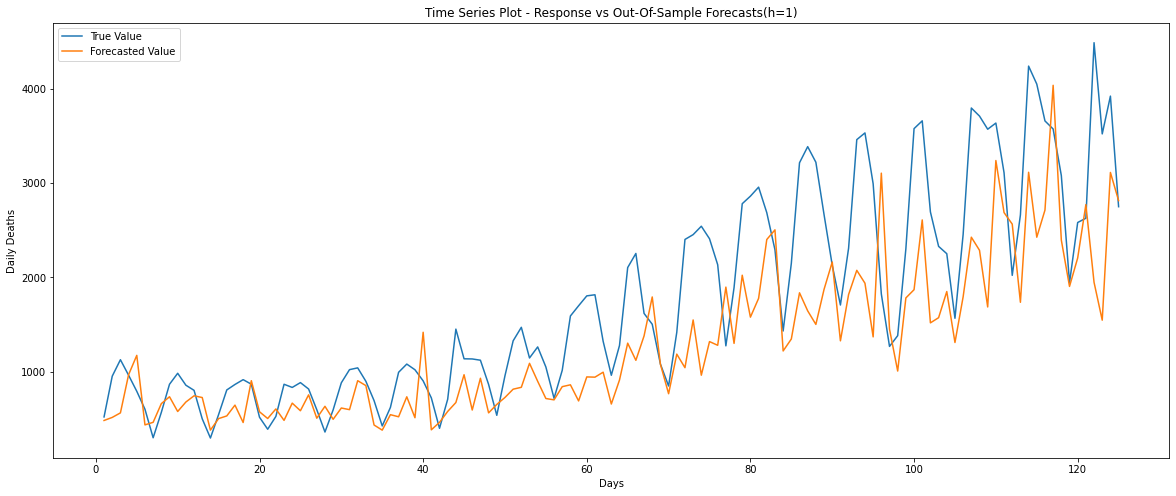

In [89]:
true_pred = [x for ind,x in enumerate(prediction[:,1].squeeze().tolist()) if (ind+1)%2==0]
true_data = [x for ind,x in enumerate(y_e.values.squeeze()[:,1].tolist()) if (ind+1)%2==0]
dates = range(1, len(true_data) + 1)
# ytick = np.arange(0, 5000, 500)
# xtick = np.arange(0, 133, 7)
plt.figure(num=0, figsize=(20,8))
plt.plot(dates,true_data)
plt.plot(dates,true_pred)
plt.legend(['True Value','Forecasted Value'])
plt.xlabel('Days')
plt.ylabel('Daily Deaths')
# plt.axis((x1,x2,0,101))
# plt.xticks(xtick)
# plt.yticks(ytick)
plt.title("Time Series Plot - Response vs Out-Of-Sample Forecasts(h=1)")
plt.show()

In [70]:
# true_pred = [x for ind,x in enumerate(prediction[:,1].squeeze().tolist()) if (ind+1)%2==0]
# true_data = [x for ind,x in enumerate(y_e.values.squeeze()[:,1].tolist()) if (ind+1)%2==0]
# dates = range(1, len(true_data) + 1)
# # ytick = np.arange(0, 5000, 500)
# # xtick = np.arange(0, 133, 7)
# plt.figure(num=0, figsize=(20,8))
# plt.plot(dates,scaler.inverse_transform(np.array(true_data).reshape(-1, 1)))
# plt.plot(dates,scaler.inverse_transform(np.array(true_pred).reshape(-1, 1)))
# plt.legend(['True Value','Forecasted Value'])
# plt.xlabel('Days')
# plt.ylabel('Daily Deaths')
# # plt.axis((x1,x2,0,101))
# # plt.xticks(xtick)
# # plt.yticks(ytick)
# plt.title("Time Series Plot - Response vs Out-Of-Sample Forecasts(h=1)")
# plt.show()

## Augmented ConvLSTM

Model: "sequential_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_41 (ConvLSTM2D) (None, 1, 10, 64)         33536     
_________________________________________________________________
flatten_41 (Flatten)         (None, 640)               0         
_________________________________________________________________
dense_41 (Dense)             (None, 28)                17948     
Total params: 51,484
Trainable params: 51,484
Non-trainable params: 0
_________________________________________________________________
None
m = 622, tr_size = 373, te_size = 249, kt = 249, h = 28
training set: (373, 4, 1, 11, 1)


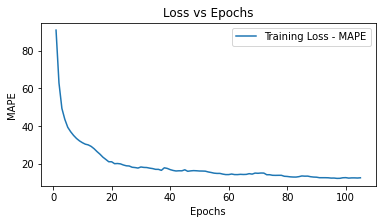

Min Training Loss = 12.215538024902344 at Epoch 97
14.07
15.96
16.99
18.08
18.79
18.01
20.49
21.72
22.72
23.56
26.24
26.99
25.58
28.78
Beats RW at 12 values of h=[2, 4, 6, 8, 10, 12, 16, 18, 20, 22, 24, 26]
Max difference = 33.05 at horizon h=6


In [115]:
from tensorflow.keras.layers import ConvLSTM2D, Flatten
rsX = pd.DataFrame(rescale(X,"linear"))
#reshapefrom[samples,timesteps]into[samples,subsequences,timesteps,features]
rX = rsX.values.reshape(rsX.shape[0],4,1,11,1) #(batch_size, timestep/window, no. features/lags)
rX.shape
cmodel = Sequential()
cmodel.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation="relu", input_shape=(4, 1, 11, 1)))
cmodel.add(Flatten())
cmodel.add(Dense(28,activation="linear"))                                     #Output Layer
cmodel.compile(loss='mean_absolute_percentage_error', optimizer="Adam", metrics=['mean_absolute_percentage_error'])
print(cmodel.summary())
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(cmodel,True,rX,Y,-1,horizons,callbk=1,nEpoch=105,nBatch=60,plot=True,p1=True,p2=True)

In [116]:
# cmodel.save('./COVID/AugConvLSTML1-43-t-f64-4-1-11-1-E100-b64.h5')

## Regular ConvLSTM

(320, 3, 1, 5, 1)
Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_47 (ConvLSTM2D) (None, 1, 4, 64)          33536     
_________________________________________________________________
flatten_47 (Flatten)         (None, 256)               0         
_________________________________________________________________
dense_47 (Dense)             (None, 14)                3598      
Total params: 37,134
Trainable params: 37,134
Non-trainable params: 0
_________________________________________________________________
None
m = 320, tr_size = 192, te_size = 128, kt = 128, h = 14
training set: (192, 3, 1, 5, 1)


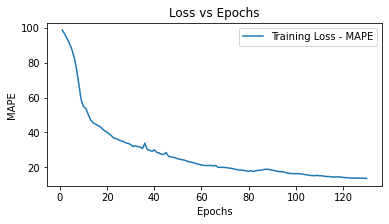

Min Training Loss = 13.653884887695312 at Epoch 130
18.15
18.48
19.31
20.28
19.55
21.13
21.30
25.28
26.52
27.89
28.47
27.95
29.97
31.54
Beats RW at 12 values of h=[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13]
Max difference = 35.44 at horizon h=3


In [129]:
from tensorflow.keras.layers import ConvLSTM2D, Flatten
rsX = pd.DataFrame(rescale(X,"linear"))
#reshapefrom[samples,timesteps]into[samples,subsequences,timesteps,features]
rX = rsX.values.reshape(rsX.shape[0],3,1,5,1) #(batch_size, timestep/window, no. features/lags)
print(rX.shape)
cmodel = Sequential()
cmodel.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation="relu", input_shape=(3, 1, 5, 1)))
cmodel.add(Flatten())
cmodel.add(Dense(14,activation="linear"))                                     #Output Layer
cmodel.compile(loss='mean_absolute_percentage_error', optimizer="Adam", metrics=['mean_absolute_percentage_error'])
print(cmodel.summary())
rSq1, mape1, smape1, mse1, rmse1, sse1, sst1, beats, prediction, y_e = rollingValidate(cmodel,True,rX,Y,-1,horizons,callbk=0,nEpoch=130,nBatch=64,plot=True,p1=True,p2=True)

In [130]:
# cmodel.save('./COVID/RegConvLSTML1-43-t-f64-4-1-11-1-E130-b64.h5')

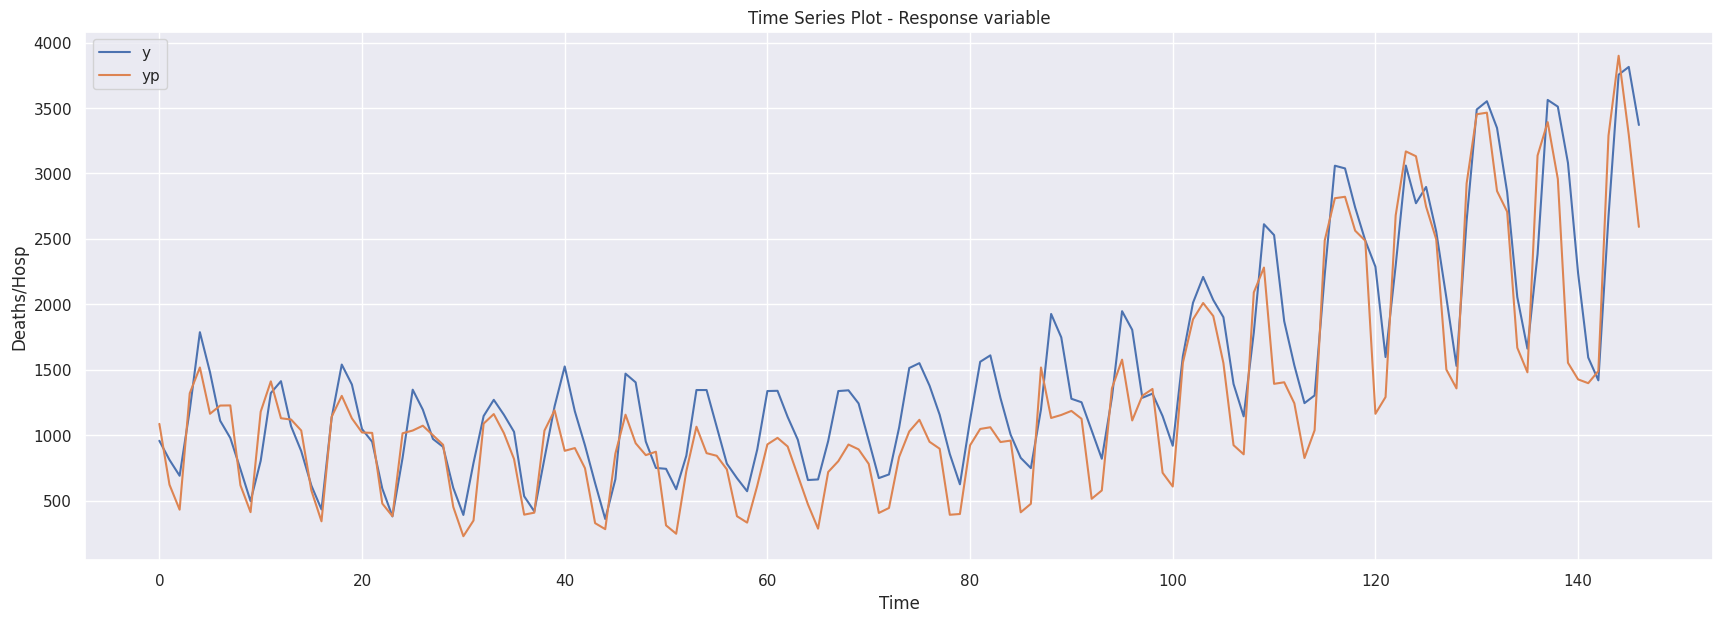

In [44]:
plt.figure(num=0, figsize=(21,7),dpi=100)
plt.plot(pd.DataFrame(prediction).iloc[:,0].values.squeeze())
plt.plot(y_e.iloc[:,0].values.squeeze())
# plt.plot(dat[['positive']])
# plt.plot(dat[['hospitalizedIncrease_alt']])
plt.legend(['y','yp'])
plt.xlabel('Time')
plt.ylabel('Deaths/Hosp')
# x1,x2,y1,y2 = plt.axis()
# plt.axis((x1,x2,0,101))
# plt.yticks(np.arange(0, 101, 10.0))
plt.title("Time Series Plot - Response variable")
plt.show()